# Simulating Chemical Reaction Networks with ppsim

``ppsim`` is able to simulate any Chemical Reaction Network (CRN) whose reactions are all bimolecular (two reactant, two product) or unimolecular (one reactant, one product). This notebook shows some examples of that feature, and how it compares to the standard Gillespie stochastic simulation algorithm.

In [1]:
import ppsim as pp
import numpy as np
from matplotlib import pyplot as plt
import pickle

# Approximate majority CRN



 Time: 30.000


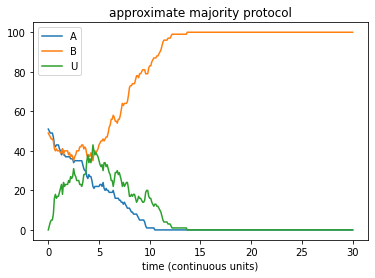

In [2]:
a,b,u = pp.species('A B U')
approx_majority = [
    a+b >> 2*u,
    a+u >> 2*a,
    b+u >> 2*b,
]
n = 10 ** 2
p = 0.51
init_config = {a: p*n, b: (1-p)*n}
sim = pp.Simulation(init_config, approx_majority)
sim.run(30, 0.1)
sim.history.plot(figsize = (6,4))
plt.title('approximate majority protocol')
plt.savefig('cmsb_data/am1.svg')
plt.show()

In [47]:
import gillespy2
class ApproximateMajority(gillespy2.Model):
     def __init__(self, n):
            #initialize Model
            gillespy2.Model.__init__(self, name="Approximate_Majority")
            
            self.volume = n
            
            rate1 = gillespy2.Parameter(name='rate1', expression= 1)
            rate2 = gillespy2.Parameter(name='rate2', expression= 1)
            rate3 = gillespy2.Parameter(name='rate3', expression = 1)
            
            # Add parameters to the model
            self.add_parameter([rate1,rate2,rate3])
            
            A = gillespy2.Species(name='A', initial_value= int(p * n))
            B = gillespy2.Species(name='B', initial_value= int((1-p) * n))
            U = gillespy2.Species(name='U', initial_value=0)
            
            # Add species to the model
            self.add_species([A, B, U])
            
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={U:2},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={A:1, U:1}, products={A:2},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={B:1, U:1}, products={B:2},
                    rate=rate3)
            
            # Add reactions to the model
            self.add_reaction([r1,r2,r3])
            
            # Set timespan of model
            self.timespan(np.linspace(0,30,300))

In [31]:
model = ApproximateMajority(10 ** 2)

In [35]:
%prun results = model.run(solver=gillespy2.NumPySSASolver, number_of_trajectories = 1000)

         2165 function calls (2162 primitive calls) in 3.423 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       16    3.408    0.213    3.408    0.213 {method 'acquire' of '_thread.lock' objects}
        1    0.009    0.009    3.423    3.423 <string>:1(<module>)
        1    0.003    0.003    0.003    0.003 solverutils.py:167(numpy_trajectory_base_initialization)
        1    0.001    0.001    3.413    3.413 model.py:781(run)
     1000    0.000    0.000    0.000    0.000 results.py:97(__init__)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000    0.000    0.000 {built-in method _thread.start_new_thread}
        1    0.000    0.000    3.412    3.412 ssa_solver.py:30(run)
     1000    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    3.423    3.423 {built-in method builtins.exec}
        1    0.000    0.000    0.000    

In [37]:
%prun results = model.run(solver=gillespy2.SSACSolver, number_of_trajectories = 10000)

         42068 function calls (42067 primitive calls) in 18.290 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    9.412    9.412    9.412    9.412 solverutils.py:78(_parse_binary_output)
       15    5.831    0.389    5.831    0.389 {method 'read' of '_io.BufferedReader' objects}
       20    2.150    0.108    2.150    0.108 {method 'acquire' of '_thread.lock' objects}
        1    0.508    0.508    0.508    0.508 {method 'split' of 'str' objects}
        1    0.161    0.161   18.131   18.131 ssa_c_solver.py:168(run)
        1    0.147    0.147   18.289   18.289 model.py:781(run)
        3    0.030    0.010    0.030    0.010 {built-in method _winapi.CreateProcess}
        1    0.015    0.015    0.015    0.015 {method 'decode' of 'bytes' objects}
       21    0.009    0.000    0.009    0.000 {built-in method io.open}
    10000    0.005    0.000    0.005    0.000 results.py:97(__init__)
       12    0.003    0.000 

In [37]:
model = ApproximateMajority(n)
model.run().plot(figsize = (6, 4))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
n = 100
p = 0.5
init_config = {a: p * n, b: (1-p)*n}
trials = 100000
end_time = 5
sim = pp.Simulation(init_config, approx_majority)
df = sim.sample_future_configuration(end_time, num_samples = trials)

model = ApproximateMajority(n)
model.timespan(np.linspace(0,end_time,2))
results = model.run(number_of_trajectories = trials)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [45]:
%matplotlib widget
for state in ['A', 'B', 'U']:
    fig, ax = plt.subplots()
    plt.hist(df[state], bins = np.linspace(0, n, 100), alpha = 0.5, label='ppsim', density=True, edgecolor = 'k', linewidth=0.2, color='g')
    plt.hist([result[state][1] for result in results], bins = np.linspace(0, n, 100), alpha = 0.5, label='gillespy2', density=True, color='b', edgecolor = 'k', linewidth=0.2)
#     plt.hist([df[state], [result[state][1] for result in results]], bins = np.linspace(0, n, 10), edgecolor = 'k', label=['ppsim', 'gillespy2'], density=True)
    plt.legend()
    plt.xlabel(f'Count of {state}')
    plt.ylabel('empirical probability')
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
import time
ns = [int(n) for n in np.geomspace(100, 10 ** 5, 10)]
gillespy_times = []
ppsim_times = []
num_trials = 1000
for n in ns:
    model = ApproximateMajority(n)
    model.timespan(np.linspace(0,10,2))
    start_time = time.perf_counter()
    r = model.run(number_of_trajectories = num_trials)
    gillespy_times.append((time.perf_counter() - start_time) / num_trials)
#     print(gillespy_times)
    sim = pp.Simulation({a: n // 2, b: n // 2}, approx_majority)
    start_time = time.perf_counter()
    c = sim.sample_future_configuration(10, num_trials)
    ppsim_times.append((time.perf_counter() - start_time) / num_trials)
#     print(ppsim_times)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

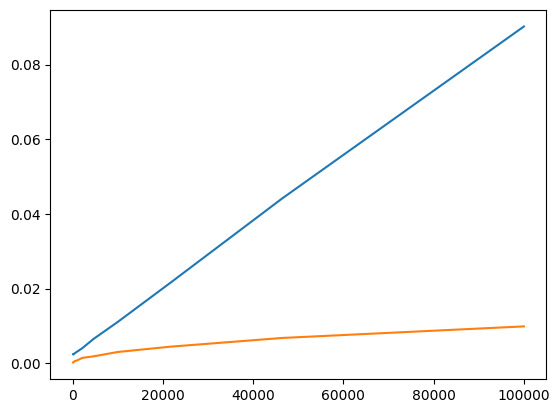

In [47]:
fig, ax = plt.subplots()
plt.plot(ns, gillespy_times)
plt.plot(ns, ppsim_times)

In [4]:
# CRN for approximate majority
k1,k2,k3 = 9028, 2945, 1815
total_concentration = 80 * 1e-9 # 1x volume was 80 nM
vol = 1e-6 # 1 uL
n = pp.concentration_to_count(total_concentration, vol)
approx_majority_rates = [
    (a+b >> 2*u).k(k1, units=pp.RateConstantUnits.mass_action),
    (a+u >> 2*a).k(k2, units=pp.RateConstantUnits.mass_action),
    (b+u >> 2*b).k(k3, units=pp.RateConstantUnits.mass_action),
]
p = 0.45
init_config = {a: p*n, b: (1-p)*n}
sim = pp.Simulation(init_config, approx_majority_rates, volume=vol, time_units='seconds')
hp = pp.HistoryPlotter()
sim.add_snapshot(hp)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
sim.run()

# Speed Test Examples

In [16]:
def get_unimolecular_chain(m):
    # create reactions with m species s0, ..., s(m-1)
    states = pp.species(' '.join([str(i) for i in range(m)]))
    rxns = [states[i] >> states[i+1] for i in range(m-1)]
    return states, rxns

In [22]:
m = 100
n = 10 ** 8
states, rxns = get_unimolecular_chain(m)
init_config = {states[0]: n}
sim = pp.Simulation(init_config, rxns)
sim.run()
sim.history.plot()

 Time: 166.000


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='time (continuous)'>

# RPS Oscillator

In [10]:
# CRN for approximate majority
k1,k2,k3 = 1, 1, 1
a,b,c = pp.species('A B C')
rps = [
    (b+a >> 2*b).k(k1),
    (c+b >> 2*c).k(k2),
    (a+c >> 2*a).k(k3),
]

In [3]:
%matplotlib widget

In [20]:
n = 10 ** 10
dist = [0.3, 0.3, 0.4]
init_config = {a: n * dist[0], b: n * dist[1], c: n * dist[2]}
sim = pp.Simulation(init_config, rps)
sim.run(100, 0.1)
sim.history.plot(figsize = (6,4))
plt.title('rps oscillator')

 Time: 100.000


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'rps oscillator')

In [12]:
sim.run()
plt.figure()
sim.history['A'].plot(figsize = (6,4))
plt.title('rps oscillator')

 Time: 3527.000


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'rps oscillator')

In [7]:
n = 10 ** 10
init_config = {a: n // 3, b: n // 3, c: n // 3}
sim = pp.Simulation(init_config, rps)

In [8]:
hp=pp.HistoryPlotter(update_time = 1)
sim.add_snapshot(hp)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
sim.run(history_interval = 0.1)

KeyboardInterrupt: 

In [23]:
class RPS(gillespy2.Model):
     def __init__(self, n):
            #initialize Model
            gillespy2.Model.__init__(self, name="RPS_Oscillator")
            
            self.volume = n
            
            rate1 = gillespy2.Parameter(name='rate1', expression= k1)
            rate2 = gillespy2.Parameter(name='rate2', expression= k2)
            rate3 = gillespy2.Parameter(name='rate3', expression = k3)
            
            # Add parameters to the model
            self.add_parameter([rate1,rate2,rate3])
            
            A = gillespy2.Species(name='A', initial_value= n * dist[0])
            B = gillespy2.Species(name='B', initial_value= n * dist[1])
            C = gillespy2.Species(name='C', initial_value= n * dist[2])
            
            # Add species to the model
            self.add_species([A, B, C])
            
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={B:2},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={B:1, C:1}, products={C:2},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={A:1, C:1}, products={A:2},
                    rate=rate3)
            
            # Add reactions to the model
            self.add_reaction([r1,r2,r3])
            
            # Set timespan of model
            self.timespan(np.linspace(0,1000,10000))

In [16]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
model = RPS(n)
results=model.run()
results.plot(figsize = (6, 4))

def phase_plot(results):
    ax = plt.figure().add_subplot(projection='3d')
    verts = [[n,0,0],[0,n,0],[0,0,n]]
    simplex = Poly3DCollection(verts, edgecolors='k', facecolors='w', alpha=0.1)
    ax.add_collection3d(simplex)

    ax.plot(results['A'], results['B'], results['C'], lw=0.5)
    ax.set_xlabel('A')
    ax.set_ylabel('B')
    ax.set_zlabel('C')
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_zlim(0, n)
    ax.set_title("rps oscillator")
    ax.grid(False)
    
    ax.scatter(results['A'][0], results['B'][0], results['C'][0], c='g', edgecolor='k')
    ax.scatter(results['A'][-1], results['B'][-1], results['C'][-1], c='r', edgecolor='k')
    plt.show()
    return(ax)
    
ax = phase_plot(results)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
model = RPS(n)
results=model.run(solver=gillespy2.TauLeapingSolver)
results.plot(figsize = (6, 4))
ax = phase_plot(results)
ax.set_title("rps oscillator with tau-leaping")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.92, 'rps oscillator with tau-leaping')

In [23]:
# For some reason gillespy2.ODESolver doesn't work
# model = RPS(3)
# model.timespan(np.linspace(0,200,2000))
results=model.run(solver=gillespy2.ODESolver)
results.plot(figsize = (6, 4))
ax = plt.figure().add_subplot(projection='3d')
ax.plot(results['A'], results['B'], results['C'])
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.set_zlabel('C')
ax.set_title("rps oscillator")
plt.show()

C:\Users\Eric\Anaconda2\lib\site-packages\scipy\integrate\_ode.py:1353: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …